In [1]:
import warnings
import math
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import math
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from fbprophet import plot
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [3]:
# http://www.tbacking.com/?p=449

In [1040]:
# https://m.blog.naver.com/silvury/220939233742

In [ ]:
# https://tykimos.github.io/2017/09/09/Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe/

In [4]:
test = pd.read_csv('data/test.csv')
feature = pd.read_csv('data/features.csv')
train = pd.read_csv('data/train.csv')

In [5]:
merged = train.merge(feature, how='left', on=['Store','Date'])
merged['Date'] = pd.to_datetime(merged['Date'])
merged['week'] = merged['Date'].dt.week
xdf = merged[(merged['Store']==1)&(merged['Dept']==1)][['week','Temperature','Fuel_Price','Weekly_Sales']]

In [6]:
df = pd.read_csv('data/timedata.csv')

In [7]:
isna = df.T.isnull().sum(axis=0) # 누락값이 있는 데이터와 없는 데이터를 분류
df_isna = df.loc[isna[isna>0].index]
df_nona = df.loc[isna[isna==0].index]#.reset_index(drop=True)
df_sd = df_nona.T.reset_index()[:2]
df_sd = df_sd.T.iloc[1:].rename(columns={0:'s',1:'d'})

df_sdn = df_isna.T.reset_index()[:2]
df_sdn = df_sdn.T.iloc[1:].rename(columns={0:'s',1:'d'})


df_td = df_nona.T.reset_index()[2:]
df_td['index'] = pd.to_datetime(df_td['index'])
df_td = df_td.rename(columns={'index':'Date'})
df_td.insert(0, 'week', df_td['Date'].dt.week)
df_td.insert(0, 'month', df_td['Date'].dt.month)
df_td.insert(0, 'year', df_td['Date'].dt.year)

df_tdn = df_isna.T.reset_index()[2:]
df_tdn['index'] = pd.to_datetime(df_tdn['index'])
df_tdn = df_tdn.rename(columns={'index':'Date'})
df_tdn.insert(0, 'week', df_tdn['Date'].dt.week)
df_tdn.insert(0, 'month', df_tdn['Date'].dt.month)
df_tdn.insert(0, 'year', df_tdn['Date'].dt.year)

In [8]:
nas = df_tdn.drop(columns=['year','month','week','Date']).isna().sum(axis=0).sort_values(ascending=False)

In [10]:
nas[(nas>110)]

1027    142
2679    142
908     142
1295    142
3170    142
1332    142
1340    142
362     142
512     142
2240    142
529     142
3101    142
2028    142
1576    142
1604    142
2563    142
738     142
2684    142
211     142
1683    142
216     142
2842    142
2698    142
1760    142
2811    142
264     142
2717    142
1912    142
1219    142
2222    142
       ... 
1194    121
2475    121
3216    120
274     120
2035    120
3038    120
3154    120
376     120
1418    119
2461    119
1031    119
799     118
1107    118
3106    118
3297    118
2694    117
2445    117
1416    116
1113    115
3116    115
1879    114
1496    113
1370    113
803     113
2817    113
2737    112
2801    112
3218    111
2809    111
2243    111
Length: 287, dtype: int64

In [14]:
df_test = test.pivot_table('IsHoliday',['Dept','Store'],'Date',aggfunc='count').reset_index()
df_test_sd = df_test[['Dept','Store']]
df_test_td = df_test.drop(columns=['Dept','Store'])

In [15]:
tmp = df_test_td.loc[df_test_td.sum(axis=1)== 39] ## 완전한 데이터
#df_test_td.loc[df_test_td.sum(axis=1)!= 39]

In [16]:
np.random.seed(7)

In [17]:
scaler = MinMaxScaler()
nptf = scaler.fit_transform(df_td[42].values.reshape(-1, 1))

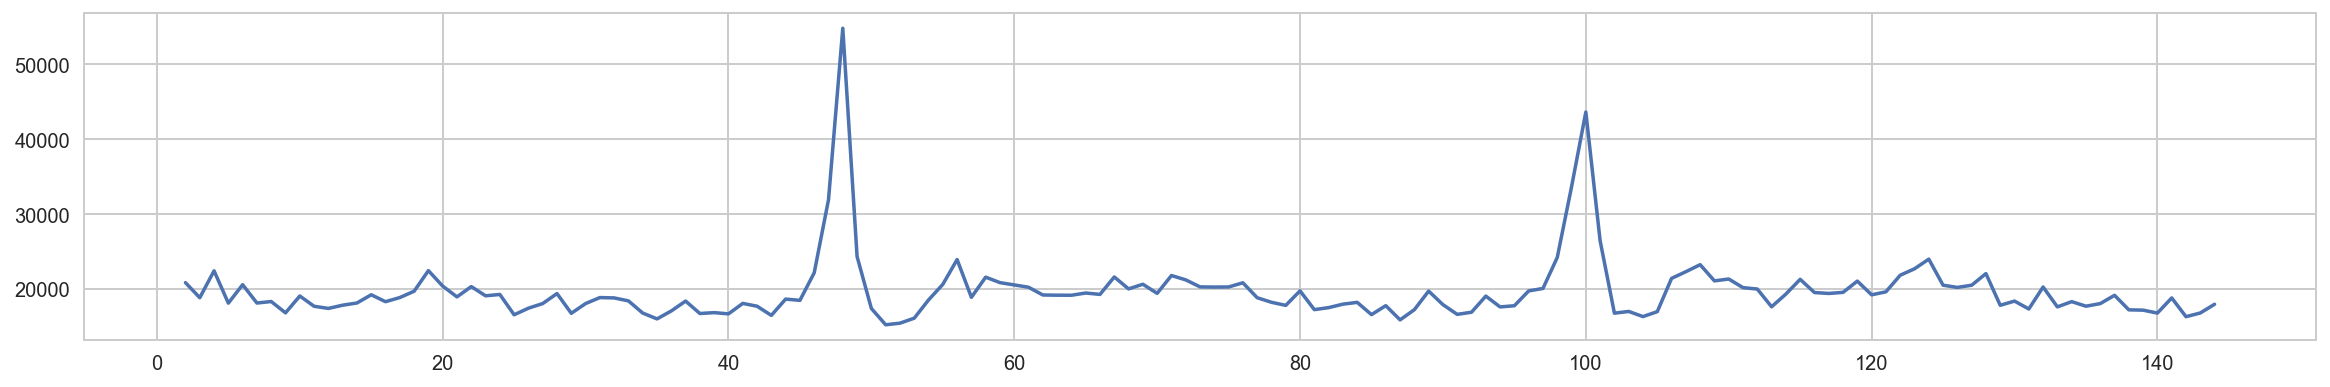

In [18]:
plt.figure(figsize=(20, 3))
plt.plot(df_td[42])

In [34]:
train = nptf

In [21]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [35]:
look_back = 4
# create dataset for learning
trainX, trainY = create_dataset(train, look_back) 

In [36]:
trainX.shape, trainY.shape

((139, 4, 1), (139, 1))

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) 

In [38]:
trainX.shape, trainY.shape

((139, 1, 4), (139, 1))

In [39]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/500
139/139 [==============================] - ETA: 1:09 - loss: 0.001 - ETA: 1s - loss: 0.0059  - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.013 - 1s 5ms/step - loss: 0.0135
Epoch 2/500
139/139 [==============================] - ETA: 0s - loss: 1.1708e-0 - ETA: 0s - loss: 0.0155    - ETA: 0s - loss: 0.008 - 0s 1ms/step - loss: 0.0122
Epoch 3/500
139/139 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.012 - 0s 1ms/step - loss: 0.0116
Epoch 4/500
139/139 [==============================] - ETA: 0s - loss: 6.3181e-0 - ETA: 0s - loss: 0.0242    - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.011 - 0s 1ms/step - loss: 0.0114
Epoch 5/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.011 - 0s 1ms/step - loss: 0.0110
Epoch 6/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.013 - ETA: 0s - l

139/139 [==============================] - ETA: 0s - loss: 1.6739e-0 - ETA: 0s - loss: 0.0023    - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.007 - 0s 1ms/step - loss: 0.0083
Epoch 44/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.008 - 0s 1ms/step - loss: 0.0082
Epoch 45/500
139/139 [==============================] - ETA: 0s - loss: 8.0096e-0 - ETA: 0s - loss: 0.0141    - ETA: 0s - loss: 0.010 - 0s 1ms/step - loss: 0.0082
Epoch 46/500
139/139 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0081
Epoch 47/500
139/139 [==============================] - ETA: 0s - loss: 7.9767e-0 - ETA: 0s - loss: 0.0229    - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.009 - 0s 1ms/step - loss: 0.0081
Epoch 48/500
139/139 [==============================] - ETA: 0s - loss: 2.7152e-0 - ETA: 0s - loss: 0.0046    - ETA: 0

139/139 [==============================] - ETA: 0s - loss: 4.1559e-0 - ETA: 0s - loss: 0.0036    - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - 0s 2ms/step - loss: 0.0071
Epoch 86/500
139/139 [==============================] - ETA: 0s - loss: 1.5992e-0 - ETA: 0s - loss: 0.0010    - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - 0s 3ms/step - loss: 0.0073
Epoch 87/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.004 - 0s 2ms/step - loss: 0.0069
Epoch 88/500
139/139 [==============================] - ETA: 0s - loss: 7.9285e-0 - ETA: 0s - loss: 0.0017    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - 0s 3ms/step - loss: 0.0071
Epoch 89/

139/139 [==============================] - ETA: 0s - loss: 5.9120e-0 - ETA: 0s - loss: 0.0104    - ETA: 0s - loss: 0.007 - 0s 1ms/step - loss: 0.0065
Epoch 125/500
139/139 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0063
Epoch 126/500
139/139 [==============================] - ETA: 0s - loss: 2.5985e-0 - ETA: 0s - loss: 0.0104    - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0064
Epoch 127/500
139/139 [==============================] - ETA: 0s - loss: 4.5867e-0 - ETA: 0s - loss: 0.0023    - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0063
Epoch 128/500
139/139 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.006 - 0s 2ms/step - loss: 0.0064
Epoch 129/500
139/139 [==============================] - ETA: 0s - loss: 2.1127e-0 - ETA: 

139/139 [==============================] - ETA: 0s - loss: 2.4185e-0 - ETA: 0s - loss: 0.0039    - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0059
Epoch 169/500
139/139 [==============================] - ETA: 0s - loss: 4.3779e-0 - ETA: 0s - loss: 0.0037    - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s 1ms/step - loss: 0.0059
Epoch 170/500
139/139 [==============================] - ETA: 0s - loss: 1.7666e-0 - ETA: 0s - loss: 0.0026    - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.006 - 0s 2ms/step - loss: 0.0060
Epoch 171/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - 0s 2ms/step - loss: 0.0060
Epoch 172/500
139/139 [==============================] - ETA: 0s - loss: 0.065 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0059
Epoch 173/500
139/

Epoch 210/500
139/139 [==============================] - ETA: 0s - loss: 2.6570e-0 - ETA: 0s - loss: 0.0025    - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0058
Epoch 211/500
139/139 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0057
Epoch 212/500
139/139 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0058
Epoch 213/500
139/139 [==============================] - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0057
Epoch 214/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0058
Epoch 215/500
139/139 [==============================] - ETA: 0s - loss: 4.8197e-0 - ETA: 0s

139/139 [==============================] - ETA: 0s - loss: 5.1819e-0 - ETA: 0s - loss: 0.0118    - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0054
Epoch 250/500
139/139 [==============================] - ETA: 0s - loss: 0.270 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0057
Epoch 251/500
139/139 [==============================] - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 3ms/step - loss: 0.0055
Epoch 252/500
139/139 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.006 - 0s 1ms/step - loss: 0.0055
Epoch 253/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - los

139/139 [==============================] - ETA: 0s - loss: 2.7059e-0 - ETA: 0s - loss: 0.0091    - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0054
Epoch 290/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0057
Epoch 291/500
139/139 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 0s 2ms/step - loss: 0.0056
Epoch 292/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0055
Epoch 293/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s 2ms/step - loss: 0.0053
Epoch 294/

139/139 [==============================] - ETA: 0s - loss: 5.2749e-0 - ETA: 0s - loss: 0.0036    - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0053
Epoch 334/500
139/139 [==============================] - ETA: 0s - loss: 5.0805e-0 - ETA: 0s - loss: 0.0029    - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0052
Epoch 335/500
139/139 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0052
Epoch 336/500
139/139 [==============================] - ETA: 0s - loss: 7.6345e-0 - ETA: 0s - loss: 0.0042    - ETA: 0s - loss: 0.003 - 0s 1ms/step - loss: 0.0051
Epoch 337/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0054
Epoch 338/500
139/139 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - ETA: 0s -

139/139 [==============================] - ETA: 0s - loss: 8.1723e-0 - ETA: 0s - loss: 0.0050    - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0050
Epoch 376/500
139/139 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0050
Epoch 377/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0049
Epoch 378/500
139/139 [==============================] - ETA: 0s - loss: 1.1219e-0 - ETA: 0s - loss: 0.0034    - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 0s 2ms/step - loss: 0.0050
Epoch 379/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - ETA: 

139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0046
Epoch 414/500
139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - 0s 2ms/step - loss: 0.0047
Epoch 415/500
139/139 [==============================] - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 0s 1ms/step - loss: 0.0045
Epoch 416/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.004 - 0s 2ms/step - loss: 0.0046
Epoch 417/500
139/139 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.004 - 0s 2ms/step - loss: 0.0047
Epoch 418/500
139/139 [===================

139/139 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0042
Epoch 457/500
139/139 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0042
Epoch 458/500
139/139 [==============================] - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - 0s 1ms/step - loss: 0.0043
Epoch 459/500
139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0041
Epoch 460/500
139/139 [==============================] - ETA: 0s - loss: 3.0272e-0 - ETA: 0s - loss: 0.0021    - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0042
Epoch 461/500
139/139 [==============================] - ETA: 0s - loss: 6.8615e-0 - ETA: 0s - loss: 0.007

139/139 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0039
Epoch 500/500
139/139 [==============================] - ETA: 0s - loss: 2.2389e-0 - ETA: 0s - loss: 0.0019    - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 0s 1ms/step - loss: 0.0040


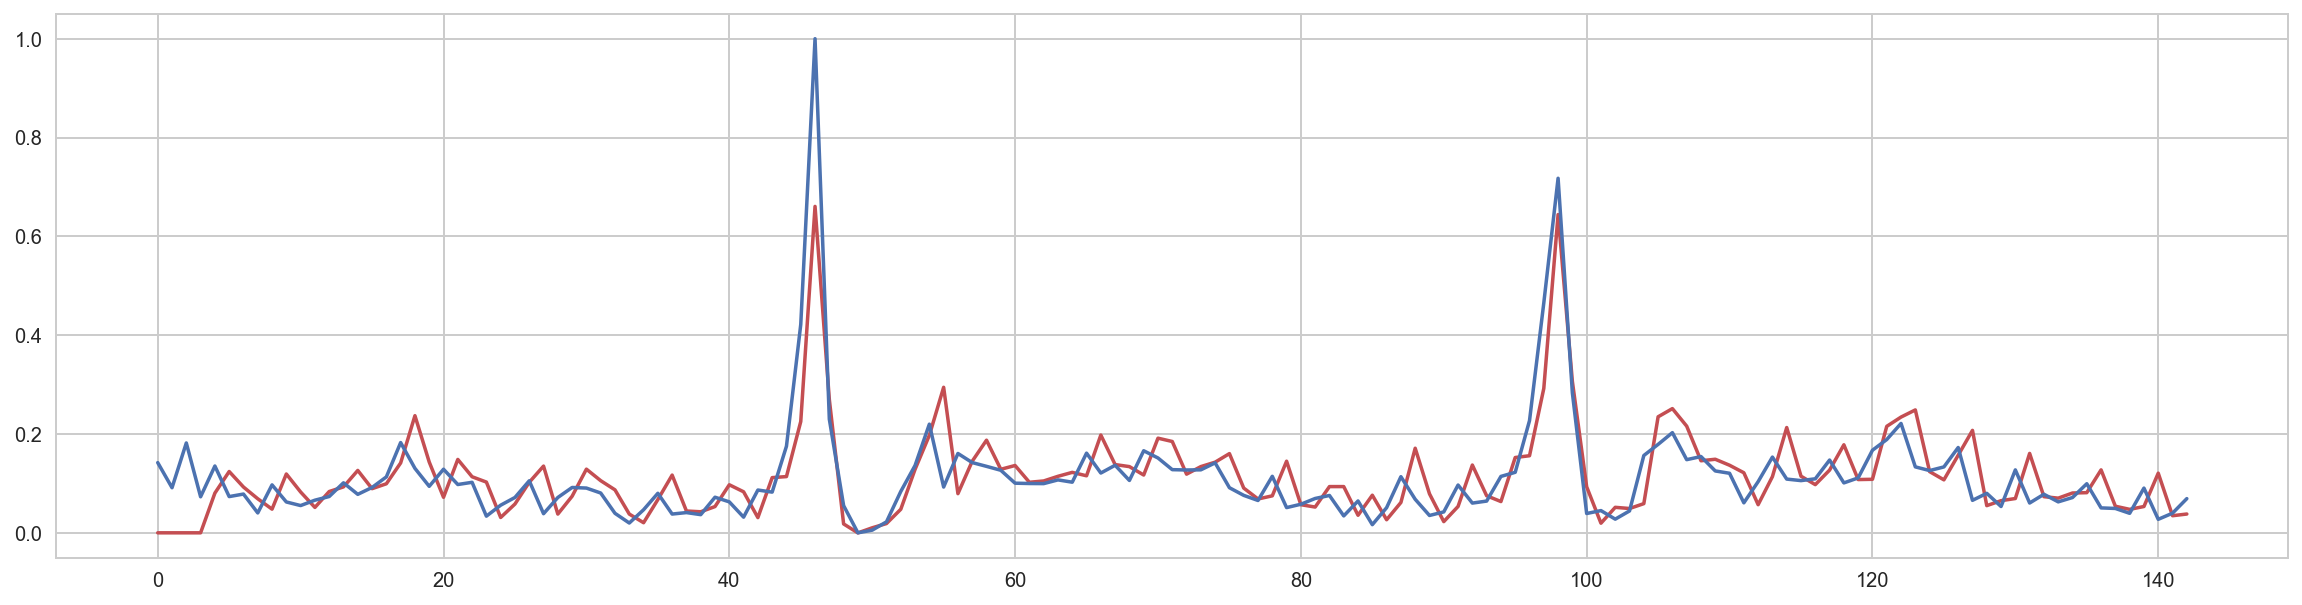

In [40]:
pred = model.predict(trainX)
#pred = scaler.inverse_transform(pred)
plt.figure(figsize=(20, 5))
plt.plot(np.insert(pred, 0, np.zeros(look_back)), c='r')
plt.plot(train)

In [41]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 700096390.54 RMSE


In [63]:
nptf[-4:]

array([[0.09050921],
       [0.02731752],
       [0.03975319],
       [0.06919183]])

In [53]:
# predict last value (or tomorrow?)
lastX = nptf[-4:]
lastX = np.reshape(lastX, (1, 1, -1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY).ravel()
print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측

Predict the Close value of final day: 19241


In [65]:
preddf = nptf.copy()
for n in range(30):
    lastX = preddf[-4:]
    lastX = np.reshape(lastX, (1, 1, -1))
    lastY = model.predict(lastX)
    lastY = scaler.inverse_transform(lastY).ravel()
    preddf = np.append(preddf, lastY)


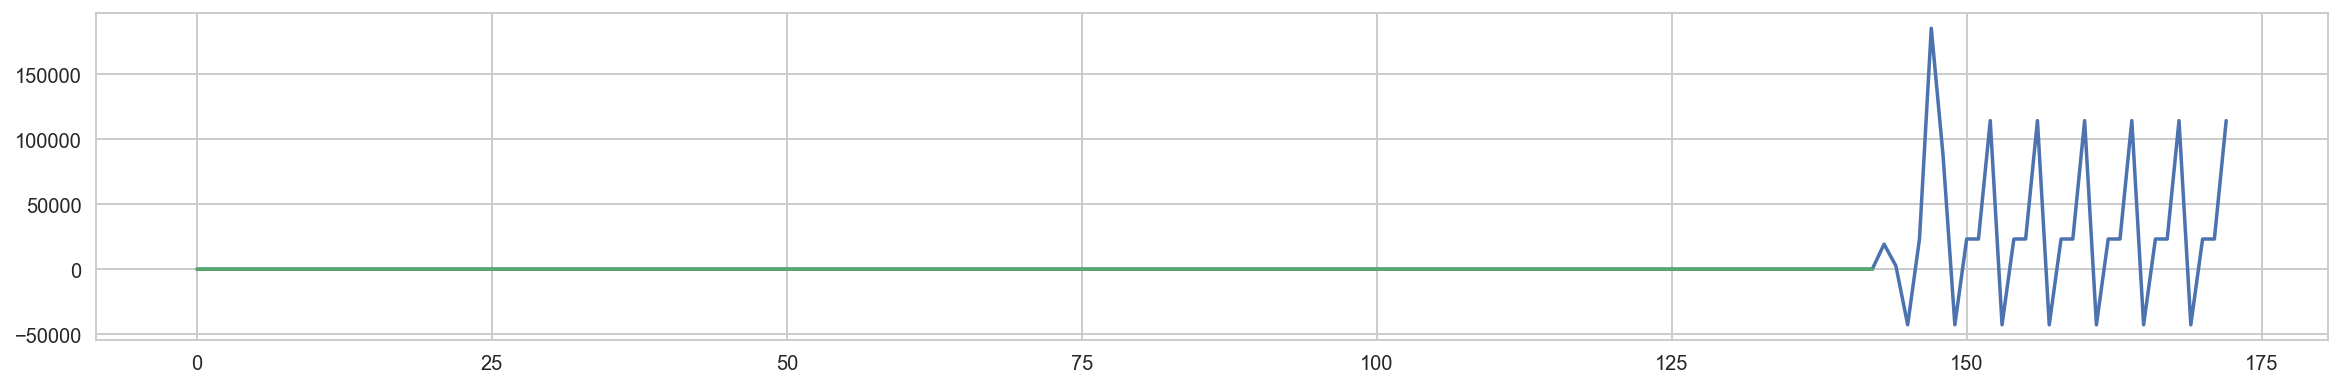

In [66]:
plt.figure(figsize=(20, 3))
plt.plot(preddf)
plt.plot(nptf)

In [ ]:
nptf

In [68]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

In [72]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - ETA: 15:48 - loss: 0.00 - ETA: 4:07 - loss: 0.0021 - ETA: 2:27 - loss: 0.002 - ETA: 1:47 - loss: 0.001 - ETA: 1:25 - loss: 0.001 - ETA: 1:12 - loss: 0.001 - ETA: 1:03 - loss: 0.001 - ETA: 56s - loss: 0.002 - ETA: 51s - loss: 0.00 - ETA: 46s - loss: 0.00 - ETA: 43s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 38s - loss: 0.02 - ETA: 36s - loss: 0.02 - ETA: 34s - loss: 0.02 - ETA: 33s - loss: 0.02 - ETA: 31s - loss: 0.02 - ETA: 30s - loss: 0.02 - ETA: 29s - loss: 0.02 - ETA: 28s - loss: 0.02 - ETA: 27s - loss: 0.02 - ETA: 27s - loss: 0.02 - ETA: 26s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.02 - ETA: 24s - loss: 0.02 - ETA: 24s - loss: 0.02 - ETA: 23s - loss: 0.02 - ETA: 23s - loss: 0.02 - ETA: 22s - loss: 0.02 - ETA: 22s - loss: 0.02 - ETA: 22s - loss: 0.02 - ETA: 21s - loss: 0.02 - ETA: 21s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02

760/760 [==============================] - ETA: 16s - loss: 0.03 - ETA: 18s - loss: 0.04 - ETA: 17s - loss: 0.03 - ETA: 17s - loss: 0.03 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02

760/760 [==============================] - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02 - ETA: 13s - loss: 0.02

760/760 [==============================] - ETA: 21s - loss: 0.00 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00

760/760 [==============================] - ETA: 24s - loss: 0.04 - ETA: 23s - loss: 0.02 - ETA: 23s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01

760/760 [==============================] - ETA: 16s - loss: 0.02 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.02 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01

760/760 [==============================] - ETA: 19s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01

760/760 [==============================] - ETA: 21s - loss: 2.4693e- - ETA: 18s - loss: 0.0021   - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - lo

760/760 [==============================] - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 18s - loss: 4.1876e- - ETA: 17s - loss: 0.0019   - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - lo

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 21s - loss: 0.00 - ETA: 18s - loss: 0.02 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00

760/760 [==============================] - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00

760/760 [==============================] - ETA: 18s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 18s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01

760/760 [==============================] - ETA: 17s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 17s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00

760/760 [==============================] - ETA: 22s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.06 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.03 - ETA: 16s - loss: 0.03 - ETA: 16s - loss: 0.03 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.03 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 16s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01

760/760 [==============================] - ETA: 21s - loss: 0.02 - ETA: 17s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 18s - loss: 1.4188e- - ETA: 19s - loss: 0.0035   - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - lo

760/760 [==============================] - ETA: 19s - loss: 0.04 - ETA: 21s - loss: 0.03 - ETA: 20s - loss: 0.05 - ETA: 19s - loss: 0.05 - ETA: 19s - loss: 0.05 - ETA: 19s - loss: 0.05 - ETA: 19s - loss: 0.05 - ETA: 19s - loss: 0.04 - ETA: 19s - loss: 0.03 - ETA: 20s - loss: 0.03 - ETA: 20s - loss: 0.03 - ETA: 19s - loss: 0.03 - ETA: 19s - loss: 0.03 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 19s - loss: 0.02 - ETA: 19s - loss: 0.02 - ETA: 19s - loss: 0.02 - ETA: 20s - loss: 0.02 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01

760/760 [==============================] - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.03 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00

760/760 [==============================] - ETA: 16s - loss: 9.7171e- - ETA: 15s - loss: 0.0053   - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - lo

760/760 [==============================] - ETA: 20s - loss: 4.0102e- - ETA: 17s - loss: 0.0028   - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - lo

760/760 [==============================] - ETA: 18s - loss: 0.03 - ETA: 17s - loss: 0.01 - ETA: 16s - loss: 0.01 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.01 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00

760/760 [==============================] - ETA: 19s - loss: 0.00 - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 17s - loss: 0.00 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 16s - loss: 8.9886e- - ETA: 15s - loss: 0.0042   - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - lo

760/760 [==============================] - ETA: 16s - loss: 3.6151e- - ETA: 15s - loss: 1.5525e- - ETA: 16s - loss: 0.0023   - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s 

760/760 [==============================] - ETA: 24s - loss: 6.1608e- - ETA: 17s - loss: 0.0049   - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - lo

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 7.7910e- - ETA: 15s - loss: 7.5469e- - ETA: 15s - loss: 0.0055   - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s 

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01

760/760 [==============================] - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.03 - ETA: 14s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 4.9118e- - ETA: 16s - loss: 0.0087   - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - lo

760/760 [==============================] - ETA: 14s - loss: 0.02 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 16s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 16s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.04 - ETA: 14s - loss: 0.02 - ETA: 15s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.02 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.01 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 1.4431e- - ETA: 14s - loss: 4.4522e- - ETA: 15s - loss: 0.0022   - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s 

760/760 [==============================] - ETA: 15s - loss: 3.2135e- - ETA: 16s - loss: 0.0043   - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - lo

760/760 [==============================] - ETA: 18s - loss: 0.03 - ETA: 19s - loss: 0.01 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.03 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01 - ETA: 12s - loss: 0.01

760/760 [==============================] - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 8.2476e- - ETA: 15s - loss: 0.0027   - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - lo

760/760 [==============================] - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.01 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.01 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00

760/760 [==============================] - ETA: 15s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00

KeyboardInterrupt: 

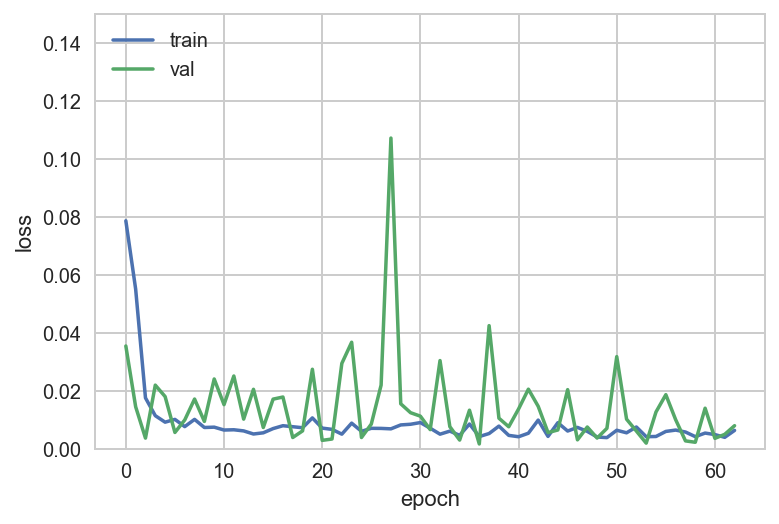

Train Score:  0.0027869282931235273
Validataion Score:  0.002875385003150023
Test Score:  0.002875385003150023


In [70]:

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

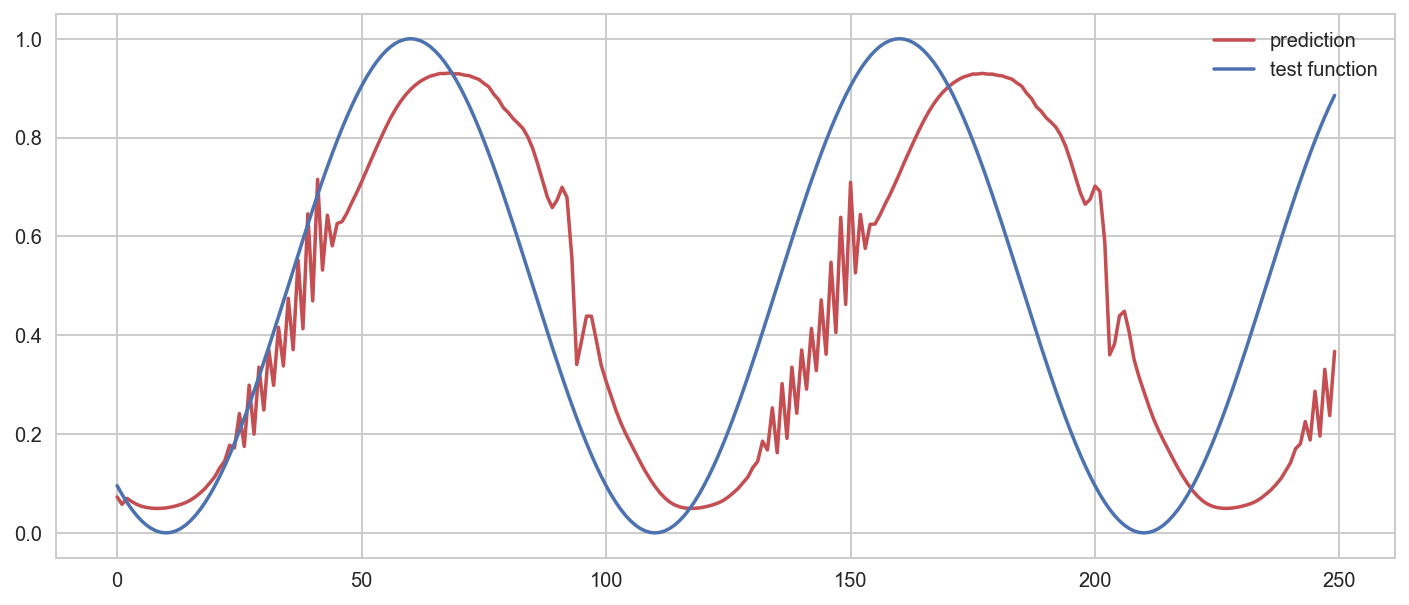

In [71]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()